In [1]:
library(magrittr)
library(stringr)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(GenomicRanges))
library(rtracklayer)
library(ggplot2)

Creating a generic function for ‘nchar’ from package ‘base’ in package ‘S4Vectors’


In [2]:
options(repr.plot.width=8, repr.plot.height=5)
# options(jupyter.plot_mimetypes = setdiff(getOption('jupyter.plot_mimetypes'), 'image/svg+xml'))

# Reformatting the original published B statistic files into the BED format

In [3]:
setwd("/mnt/scratch/mp/EMH/Bstat/")

## Load the McVicker et al. data

In [4]:
bstat_files <- list.files("/mnt/sequencedb/McVicker/bkgd", full.names=TRUE, "chr[0-9]+.bkgd")

# load B statistic values from McVicker et al. for all autosomal regions
# (as a list of data frames, one per chromosome)
bstat_df_list <- lapply(bstat_files, function(filename) {
    read.table(filename, col.names=c("bstat", "length")) %>%
        mutate(chr=as.integer(str_extract(basename(filename), "\\d+")),
               end=cumsum(length),
               start=c(1, (end + 1)[-n()])) %>%
        select(chr, start, end, bstat)
})

# concatenate the list of data frames into a single GRanges object
bstat_regions <-
    do.call(rbind, bstat_df_list) %>%
    arrange(chr, start) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

head(bstat_regions)

GRanges object with 6 ranges and 1 metadata column:
      seqnames           ranges strand |     bstat
         <Rle>        <IRanges>  <Rle> | <integer>
  [1]        1 [     1, 437756]      * |       994
  [2]        1 [437757, 641793]      * |       988
  [3]        1 [641794, 731430]      * |       982
  [4]        1 [731431, 779891]      * |       976
  [5]        1 [779892, 810659]      * |       970
  [6]        1 [810660, 831993]      * |       964
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

## An example of actual contents of McVicker et al. files
```
$> head /mnt/sequencedb/McVicker/bkgd/chr1.bkgd
994 437756
988 204037
982 89637
976 48461
970 30768
964 21334
```

In [5]:
sum(as.numeric(width(bstat_regions))) - sum(as.numeric(width(reduce(bstat_regions))))

[1] 0

## Perform the liftover from hg18 to hg19

In [6]:
# download the liftover chain file if it doesn't exist yet
if (! file.exists("hg18ToHg19.over.chain")) {
    system("wget http://hgdownload.cse.ucsc.edu/goldenPath/hg18/liftOver/hg18ToHg19.over.chain.gz")
    system("gunzip hg18ToHg19.over.chain.gz")
}

In [7]:
chain <- import.chain("hg18ToHg19.over.chain")

In [8]:
seqlevelsStyle(bstat_regions) <- "UCSC"
bstat_regions_hg19 <- liftOver(bstat_regions, chain) %>% unlist

In [9]:
sum(as.numeric(width(bstat_regions_hg19))) - sum(as.numeric(width(reduce(bstat_regions_hg19))))

[1] 1046184

## Differences between hg18 and hg19 version of B statistic regions?

### sizes and numbers of regions in hg18 and hg19 versions of the McVicker et al. data

In [10]:
# distribution of lengths of regions from McVicker et al. (hg18 version)
width(bstat_regions) %>% summary

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       1       85      188      661      459 22150000 

In [11]:
# distribution of lengths of regions from McVicker et al. (hg19 version)
width(bstat_regions_hg19) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1      85     188     617     459 3816000 

In [12]:
# number of regions from McVicker et al. (hg18 version)
length(bstat_regions)

[1] 4337212

In [13]:
# number of regions from McVicker et al. (hg19 version)
length(bstat_regions_hg19)

[1] 4342270

Overall, the number of distinct regions after liftOver is slightly higher while length of a largest region after liftOver is much lower. Therefore, the liftOver operation causes the largest regions to be broken down into smaller ones.

## Use the lifted data for further analysis

In [14]:
bstat_regions <- bstat_regions_hg19

In [15]:
seqlevelsStyle(bstat_regions) <- "NCBI"
seqlevels(bstat_regions, force=TRUE) <- as.character(1:22)

# Assigning SNPs from the archaic admixture array to B statistic bins

### Load Qiaomei's assignment of archaic admixture array SNPs into 10 bins

In [16]:
qiaomeis_10bin_snps <-
    read.table("/mnt/454/Carbon_beast_QM/Mateja_Nean_later/Oase1_x_lo25_c_p_LSB_relax_Nea_YRI.Bscor_final.bed", 
               col.names=c("chr", "start", "end", "id", "afr", "arch", "bin"),
               stringsAsFactors=FALSE) %>%
    select(-id) %>%
    filter(bin != "-") %>%
    mutate(bin=as.integer(bin)) %>%
    mutate(bin=bin + 1) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE, keep.extra.columns=TRUE)

### Reduce her 10 bins into 5 for comparison

In [17]:
# "translation" table
bin_table <- c(1, 1, 2, 2, 3, 3, 4, 4, 5, 5)

qiaomeis_5bin_snps <- qiaomeis_10bin_snps

# replace bins 1-10 with bins 1-5
qiaomeis_5bin_snps$bin <- bin_table[qiaomeis_10bin_snps$bin]

### Take from Qiaomei's data everything except her bin assignment so we can do our own

In [18]:
array_sites <- qiaomeis_10bin_snps[, c("afr", "arch")]

### Assign a B statistic value to each SNP on the array

In [19]:
# take only SNPs which actually lie within some McVicker et al. annotated region
bstat_snps <- subsetByOverlaps(array_sites, bstat_regions)

# get the pairings of SNP sites and corresponding B statistic regions
hits <- findOverlaps(array_sites, bstat_regions)

# take the B statistic values
bstat_values <- IntegerList(split(bstat_regions$bstat[subjectHits(hits)], queryHits(hits)))

# assign B statistic values to each SNP
mcols(bstat_snps) <- DataFrame(bstat=bstat_values)

There are some weird cases where a SNP falls within two different regions. However, this happens only when I perform liftOver on the original B statistic regions. Luckily, there are not that many of these SNPs, so I'll just filter them out. This could be a bug in the `liftOver` function from the `rtracklayer` package.

In [20]:
# which are the weird cases?
bstat_snps[which(elementLengths(bstat_snps$bstat) > 1)]

# filter them out
bstat_snps <- bstat_snps[-c(which(elementLengths(bstat_snps$bstat) > 1))]

# convert the bstat column (IntegerList type) to a normal vector
bstat_snps$bstat <- unlist(bstat_snps$bstat)

GRanges object with 104 ranges and 1 metadata column:
        seqnames                 ranges strand   |         bstat
           <Rle>              <IRanges>  <Rle>   | <IntegerList>
    [1]        2 [110464389, 110464389]      *   |       964,773
    [2]        4 [ 69233328,  69233328]      *   |       561,952
    [3]        4 [ 69238325,  69238325]      *   |       564,952
    [4]        4 [ 69240304,  69240304]      *   |       565,952
    [5]        4 [ 69241447,  69241447]      *   |       565,952
    ...      ...                    ...    ... ...           ...
  [100]       10   [81325801, 81325801]      *   |       952,946
  [101]       10   [81339663, 81339663]      *   |       952,946
  [102]       10   [81368410, 81368410]      *   |       952,946
  [103]       10   [81370491, 81370491]      *   |       952,946
  [104]       10   [81370949, 81370949]      *   |       952,946
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

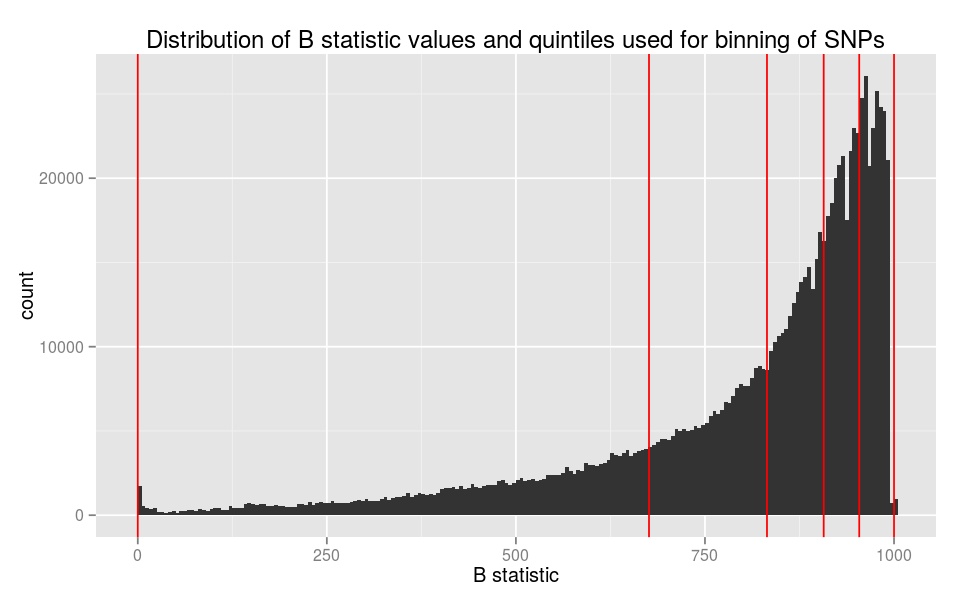

In [21]:
qplot(bstat_snps$bstat, binwidth=5, xlab="B statistic", main="Distribution of B statistic values and quintiles used for binning of SNPs")+
    geom_vline(xintercept=quantile(bstat_snps$bstat, prob=seq(0, 1, 0.2)), color="red")

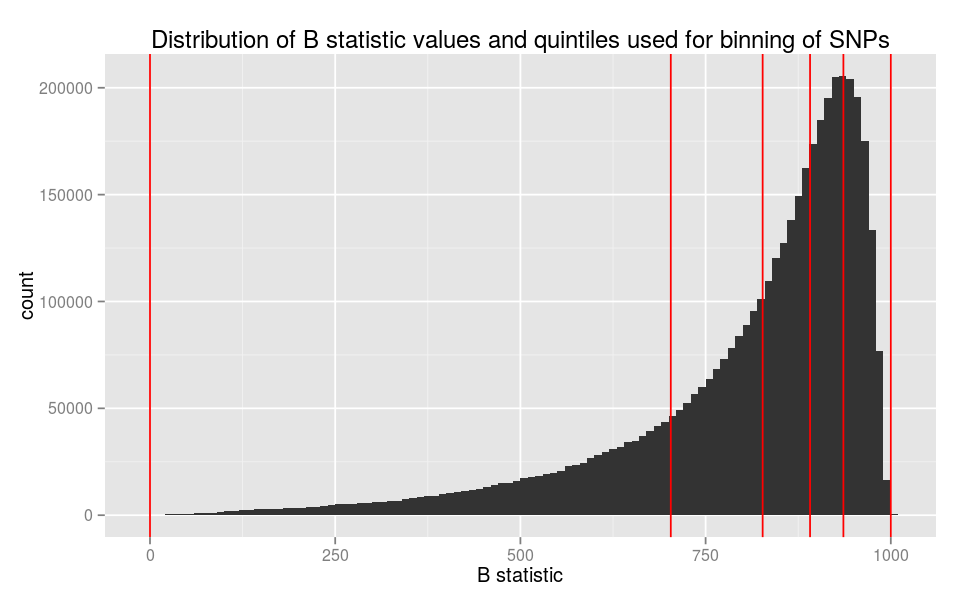

In [22]:
qplot(bstat_regions$bstat, binwidth=10, xlab="B statistic", main="Distribution of B statistic values and quintiles used for binning of SNPs")+
    geom_vline(xintercept=quantile(bstat_regions$bstat, prob=seq(0, 1, 0.2)), color="red")

## Split the SNPs into bins based on their B statistic value

In [23]:
qs <- quantile(bstat_snps$bstat, probs=seq(0, 1, 0.2))

# assign each SNP into a bin
bstat_snps$bin <- findInterval(bstat_snps$bstat, qs, rightmost.closed=TRUE)

# split the SNPs into bins
bstat_bins <- split(bstat_snps, bstat_snps$bin)

## Check the distribution of B statistic values for regions in each bin

This is just a sanity check to see if `findInterval` function above is doing what I think it's doing.

In [24]:
for (i in seq_along(bstat_bins)) {
    cat("bin", i, "\n")
    summary(bstat_bins[[i]]$bstat) %>% print
    cat("\n")
}

bin 1 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   374.0   515.0   471.5   609.0   675.0 

bin 2 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  676.0   727.0   770.0   764.4   804.0   831.0 

bin 3 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    832     855     875     873     892     906 

bin 4 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  907.0   920.0   933.0   931.5   943.0   953.0 

bin 5 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  954.0   964.0   974.0   974.2   984.0  1000.0 



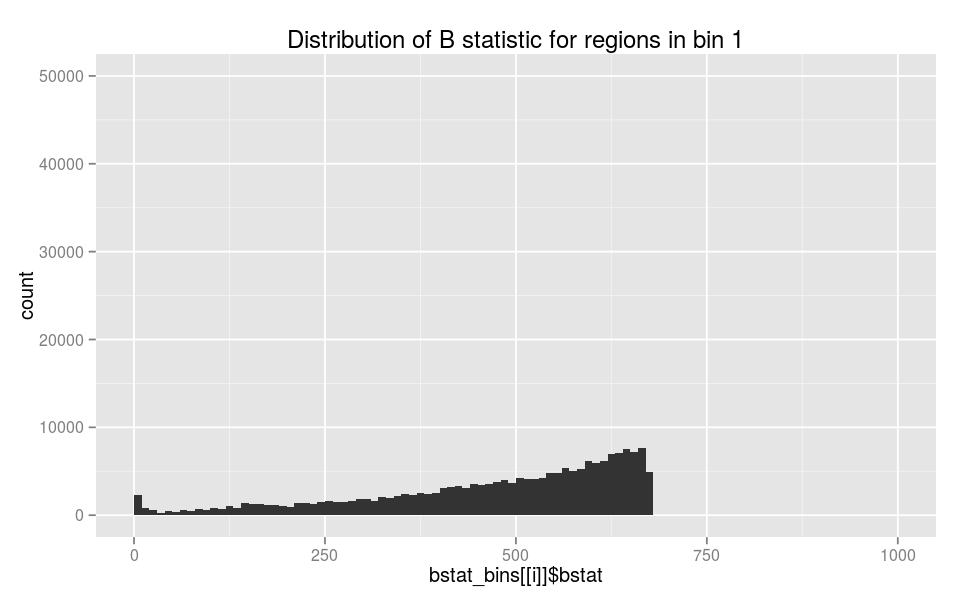

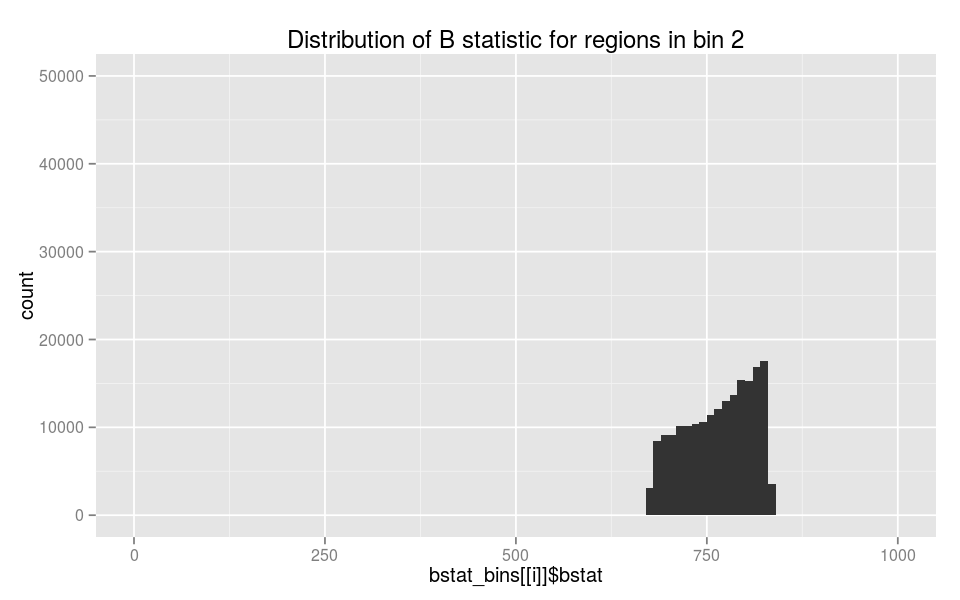

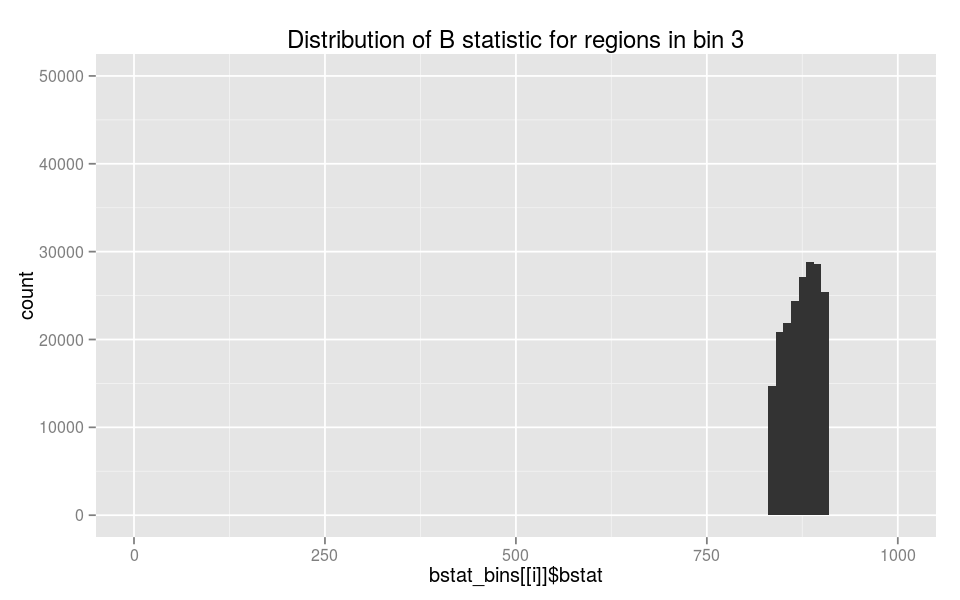

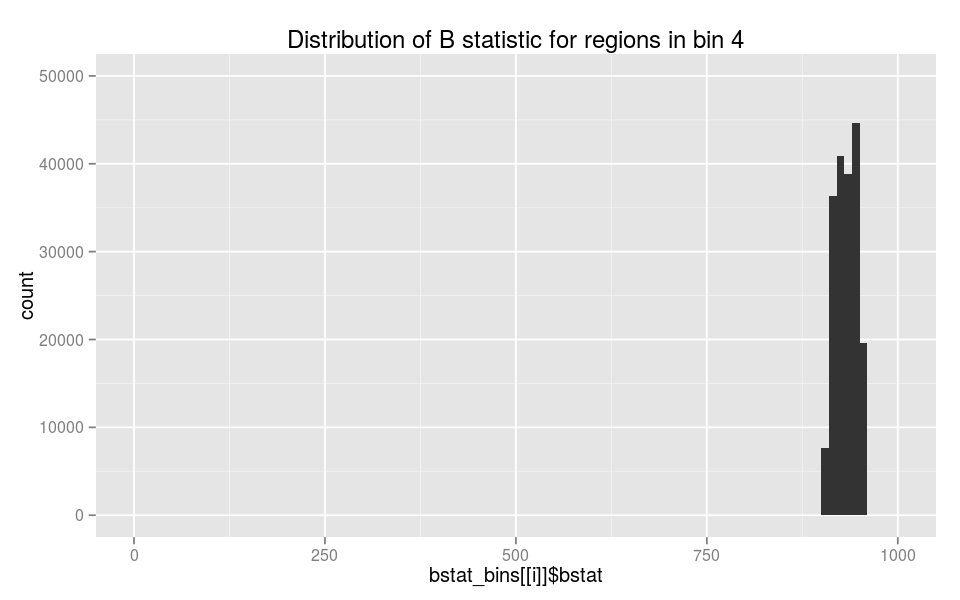

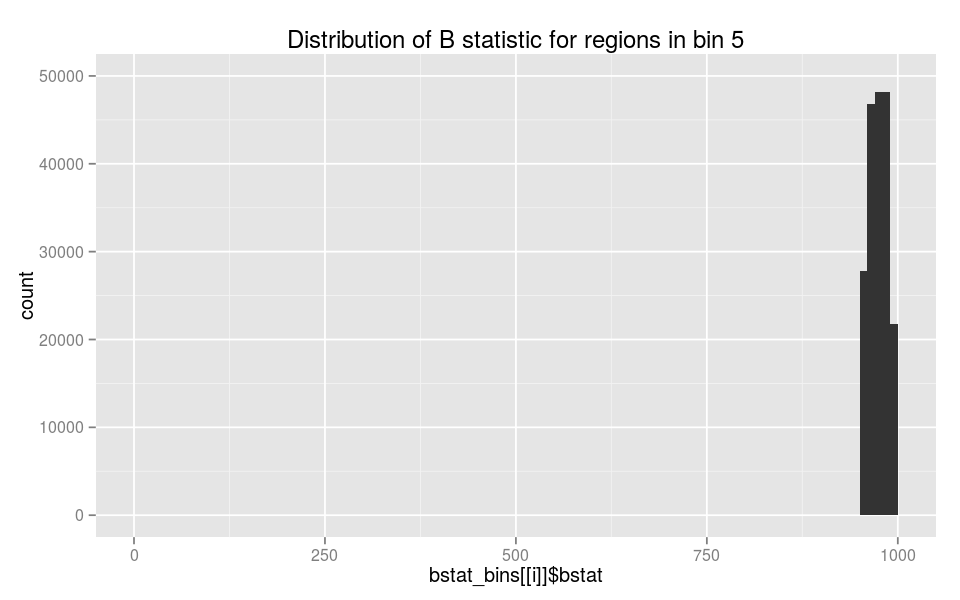

In [25]:
for (i in seq_along(bstat_bins)) {
    plot(qplot(bstat_bins[[i]]$bstat, xlim=c(0, 1000), ylim=c(0, 50000), main=paste("Distribution of B statistic for regions in bin", i), binwidth=10))
}

### Save the bin per SNP table as a BED file

In [26]:
# write out the BED file (the trickery is necessary because export.bed doesn't allow
# to specify columns to output)
as.data.frame(bstat_snps) %>%
    select(seqnames, start, end, bin) %>%
    mutate(start=start - 1) %>%
    arrange(seqnames, start) %>%
    write.table("martins_snp_bins_based_on_bstat_snp_values.bed", sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

### Save the B statistic per SNP table as a BED file

In [28]:
# write out the BED file (the trickery is necessary because export.bed doesn't allow
# to specify columns to output)
as.data.frame(bstat_snps) %>%
    select(seqnames, start, end, bstat) %>%
    mutate(start=start - 1) %>%
    arrange(seqnames, start) %>%
    write.table("martins_snp_bstat_values.bed", sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

# Check distribution of number of SNPs in each bin

stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


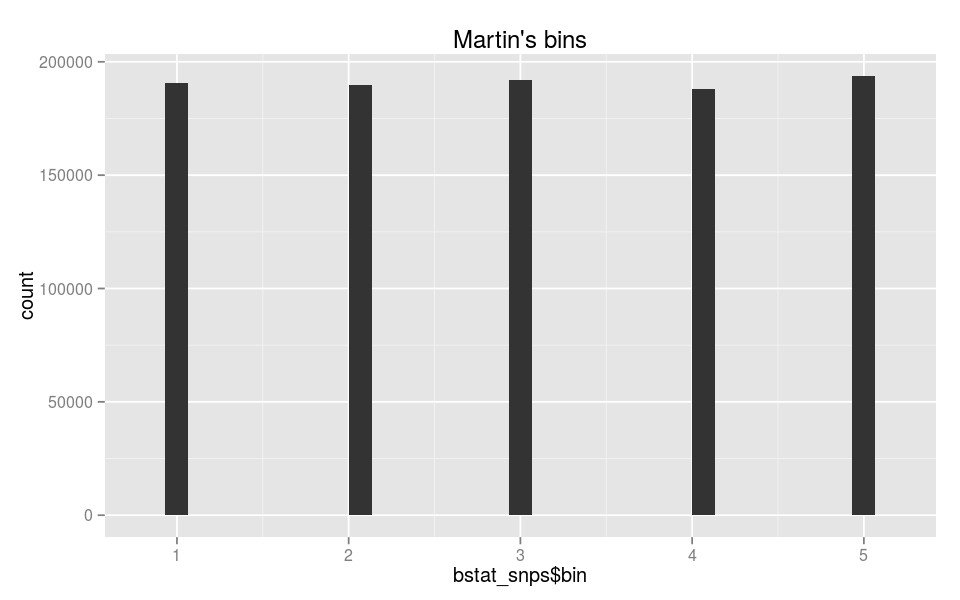

In [29]:
qplot(bstat_snps$bin, geom="bar", main="Martin's bins")

stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


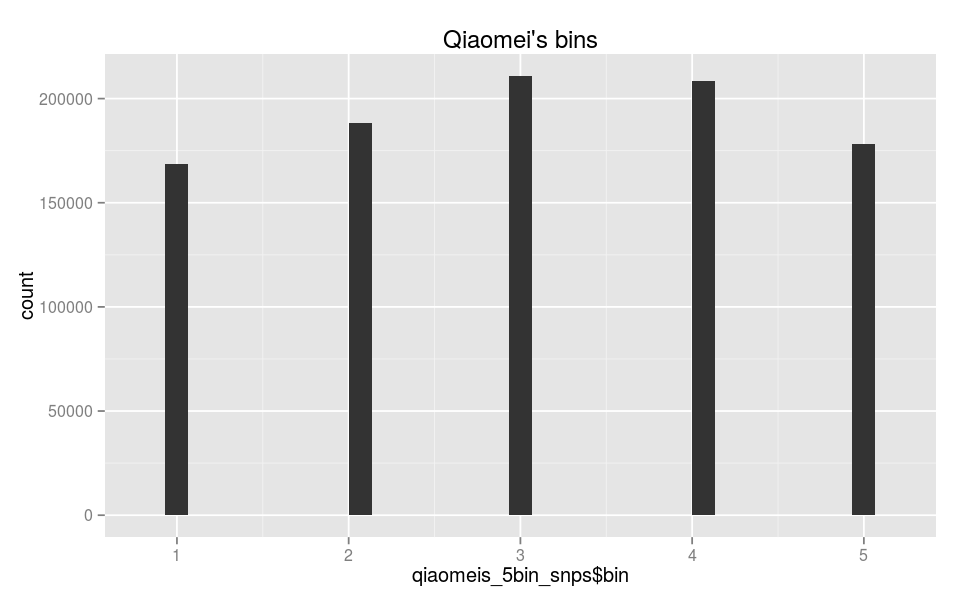

In [30]:
qplot(qiaomeis_5bin_snps$bin, geom="bar", main="Qiaomei's bins")

<br><br><br>
Approach to get B statistic values for each SNP: https://support.bioconductor.org/p/54470/